In [1]:
import sys
sys.path.append('../../../src')
from helpers import *
%matplotlib notebook

if not os.path.exists('Figs'):
    os.mkdir('Figs')

In [2]:
df = pd.read_csv('../../Raw analysis/PH rundown/NEBD_Embryos_dataframe.csv')
df_quantification = pd.read_csv('../../Raw analysis/PH rundown/Quantification.csv')
df_quantification_grouped = df_quantification.groupby('EmbryoID')

df_summary = pd.DataFrame()
for i, r in df_quantification_grouped:
    cyt = np.mean(r['Cytoplasmic signal'])
    mem_tot = np.mean(r['Membrane signal'])
    mem_ant = bounded_mean_1d(r['Membrane signal'], [0.4, 0.6])
    mem_post = bounded_mean_1d(r['Membrane signal'], [0.9, 0.1]) 
    p = {'EmbryoID': i, 'Cyt': cyt, 'Mem_tot': mem_tot, 'Mem_ant': mem_ant, 'Mem_post': mem_post} 
    df_summary = df_summary.append(pd.DataFrame(p, index=[i]))
df = pd.merge(df, df_summary, on='EmbryoID')

# Add uniform vs polarised column
df['UniPol'] = 'Uni'

# Filter
df = df[df.Line == 'od58']

### Fitting functions

In [3]:
import scipy.odr as odr
from scipy.optimize import curve_fit

def linear_model(x, a, b):
    return a * x + b

def single_fit(cyt, mem):
#     popt, pcov = curve_fit(linear_model, cyt, mem, maxfev=20000)
    p = np.polyfit(cyt, mem, 1)
    return p

def bootstrap_fitting(cyts, mems, n=1000):
    params = np.zeros([n, 2])
    for i in range(n):  
        inds = np.random.choice(range(len(cyts)), len(cyts))
        params[i, :] = single_fit(cyts[inds], mems[inds])
    return params

class ExponentConfidenceInterval:
    def __init__(self, df, whole_embryo=False):
        # Input
        self.cyts = np.log10(df.Cyt.to_numpy())
        if not whole_embryo:
            self.mems = np.log10(df.Mem_post.to_numpy())
        else:
            self.mems = np.log10(df.Mem_tot.to_numpy())
        self.unipol = df.UniPol.tolist()
        self.run()
        
    def run(self, n_bootstrap=1000, n_x=100, interval=95):
        self.res_x = np.linspace(min(self.cyts), max(self.cyts), n_x)

        # Analysing full dataset
        popt_full = single_fit(self.cyts, self.mems)
        self.res_y = linear_model(self.res_x, *popt_full)
        self.exponent_full = popt_full[0]

        # Bootstrapping
        params = bootstrap_fitting(self.cyts, self.mems)
        self.exponents = params[:, 0]

        # Confidence interval
        all_fits = np.zeros([n_bootstrap, n_x])
        for i, p in enumerate(params):
            all_fits[i, :] = linear_model(self.res_x, *p)
        self.all_fits_lower = np.percentile(all_fits, (100 - interval) / 2, axis=0)
        self.all_fits_upper = np.percentile(all_fits, 50 + (interval / 2), axis=0)

### Plotting functions

In [4]:
def plot_rundown_ci(ax, res, color):
    ax.plot(res.res_x, res.res_y, c=color, zorder=0, linewidth=1)
    ax.fill_between(res.res_x, res.all_fits_lower, res.all_fits_upper, alpha=0.1, color=color)
    ax.set_xlabel('Cytoplasmic conc. (a.u.)', fontsize=9)
    ax.set_ylabel('Membrane conc. (a.u.)', fontsize=9)
    ax.tick_params(axis='both', labelsize=8)
    ax.scatter(res.cyts, res.mems, color=color, linewidth=0.1, edgecolors='k', s=20)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    for i in np.arange(-10, 10, 0.5):
        ax.plot([-10, 10], [i - 10, i + 10], c='0.9', zorder=-100, linewidth=1)
    ax.set_xticks(np.arange(0, 10))
    ax.set_yticks(np.arange(0, 10))
    minor_ticks(ax, [0, 10], [0, 10])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.xaxis.set_major_formatter(fake_log)
    ax.yaxis.set_major_formatter(fake_log) 
    
#     ax.set_ylim(2, 5)
    ax.set_aspect('equal', adjustable='datalim')

    
import scipy.stats as st

def violin(ax, res, xpos, color):
    kde = st.gaussian_kde(res.exponents)
    xx = np.linspace(min(res.exponents), max(res.exponents), 10000)
    kde_xx = kde(xx)
    ax.fill_betweenx(xx, xpos - 0.8 * (kde_xx / max(kde_xx)), 
                     xpos + 0.8 * (kde_xx / max(kde_xx)), color=color, linewidth=0)
    ax.plot([xpos, xpos], [np.percentile(res.exponents, 2.5), np.percentile(res.exponents, 97.5)], c='k', 
            linewidth=0.5)
    ax.scatter(xpos, res.exponent_full, c='k', s=5)

### For paper

In [5]:
analysis = ExponentConfidenceInterval(df, whole_embryo=True)

<IPython.core.display.Javascript object>


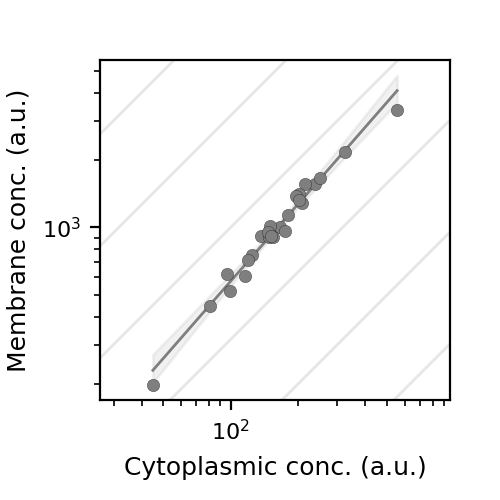

In [6]:
fig, ax = plt.subplots()
plot_rundown_ci(ax, analysis, 'tab:gray')
fig.set_size_inches(2.5, 2.5)
fig.subplots_adjust(left=0.2, bottom=0.2)
fig.savefig('Figs/ph_rundown_log.png', dpi=600, transparent=True)

<IPython.core.display.Javascript object>


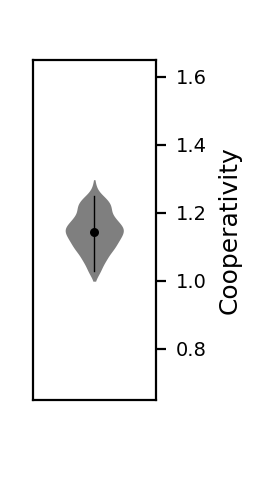

In [7]:
fig, ax = plt.subplots()
violin(ax, analysis, 1, 'tab:gray')
ax.set_xlim(-0.7, 2.7)
ax.set_ylim(0.65, 1.65)
ax.set_xticks([])
# ax.set_xticklabels(['PH'])
ax.set_ylabel('Cooperativity', fontsize=9)
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='x', labelsize=9)
# ax.set_yticks([1, 1.1, 1.2, 1.3])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

fig.set_size_inches(1.3, 2.5)
fig.subplots_adjust(bottom=0.2, right=0.6)
fig.savefig('Figs/ph_exponent.png', dpi=600, transparent=True)